<a href="https://colab.research.google.com/github/ohyunju/projects/blob/ohyunju-patch-2/project2/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Google Colab으로 수행한다면 이 셀을 먼저 실행해주세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install lightgbm
    !pip install shap
    !pip install PDPbox

In [4]:
from google.colab import files
upload=files.upload()


Saving winemag-data_first150k.csv to winemag-data_first150k.csv
Saving winequalityN.csv to winequalityN.csv


winemag-data_first150k.csv 은 https://www.kaggle.com/zynicide/wine-reviews/data

winequalityN.csv 은 https://www.kaggle.com/rajyellow46/wine-quality

에서 가져와 활용하였습니다.




# 와인 성분 분석

## 와인의 성분 전체 데이터

In [83]:
import pandas as pd

winequalityN= pd.read_csv('winequalityN.csv')
winequalityN

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [84]:
winequalityN.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [85]:
winequalityN.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
type,6497,2,white,4898,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fixed acidity,6487,NaN,NaN,NaN,7.21658,1.29675,3.8,6.4,7,7.7,15.9
volatile acidity,6489,NaN,NaN,NaN,0.339691,0.164649,0.08,0.23,0.29,0.4,1.58
citric acid,6494,NaN,NaN,NaN,0.318722,0.145265,0,0.25,0.31,0.39,1.66
residual sugar,6495,NaN,NaN,NaN,5.44433,4.75812,0.6,1.8,3,8.1,65.8
chlorides,6495,NaN,NaN,NaN,0.0560416,0.035036,0.009,0.038,0.047,0.065,0.611
free sulfur dioxide,6497,NaN,NaN,NaN,30.5253,17.7494,1,17,29,41,289
total sulfur dioxide,6497,NaN,NaN,NaN,115.745,56.5219,6,77,118,156,440
density,6497,NaN,NaN,NaN,0.994697,0.00299867,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6488,NaN,NaN,NaN,3.2184,0.160748,2.72,3.11,3.21,3.32,4.01


fixed acidity = 고정산도

volatile acidity = 휘발성산

citric acid = 구연산(시트르산)
 
residual sugar = 잔류 당

chlorides = 염화물

free sulfur dioxide = 유리 이산화황

total sulfur dioxide = 총 이산화황

density = 밀도

pH = 산도(수소 이온 농도)

sulphates = 황산염 

alcohol = 알코올 도수

quality = 와인 품질(나쁨:0 ~ 좋음:10)

In [86]:
corr=winequalityN.corr()
corr_rank=corr.sort_values(by=['quality'],axis=0,ascending=False)
corr_rank['quality']

# alcohol 이 제일 상관관계가 제일 높다                 

quality                 1.000000
alcohol                 0.444319
citric acid             0.085706
free sulfur dioxide     0.055463
sulphates               0.038729
pH                      0.019366
residual sugar         -0.036825
total sulfur dioxide   -0.041385
fixed acidity          -0.077031
chlorides              -0.200886
volatile acidity       -0.265953
density                -0.305858
Name: quality, dtype: float64

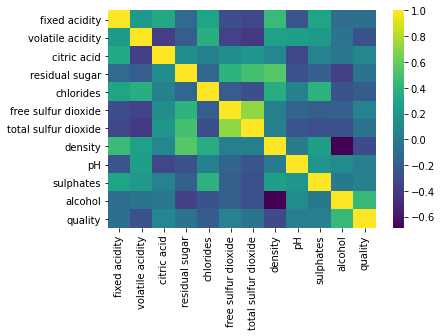

In [87]:
import seaborn as sns
sns.heatmap(corr, cmap='viridis')

### 선형회귀

In [88]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(winequalityN, test_size=0.2, random_state=2)
print(train.shape, test.shape)

train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape

(5197, 13) (1300, 13)


((4157, 13), (1040, 13))

In [89]:
target = 'quality'
feature = winequalityN.columns.drop([target])
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [90]:
from sklearn.linear_model import LinearRegression
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

linear = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),  
    LinearRegression()
)
                                     
linear.fit(X_train, y_train)

# 회귀계수
coefficients = linear.named_steps['linearregression'].coef_
pd.Series(coefficients, feature)

type                    -0.370838
fixed acidity            0.058932
volatile acidity        -1.436759
citric acid              0.017115
residual sugar           0.052722
chlorides               -0.900286
free sulfur dioxide      0.005592
total sulfur dioxide    -0.001394
density                -81.073765
pH                       0.334508
sulphates                0.644006
alcohol                  0.243629
dtype: float64

### 분류 문제

In [91]:
# quality 가 6.5이상이면 Good으로 생각
winequalityN['recommend'] = winequalityN['quality'] >= 6.5
winequalityN['recommend'].value_counts()

False    5220
True     1277
Name: recommend, dtype: int64

In [92]:
from sklearn.metrics import accuracy_score
target='recommend'

baseline=winequalityN[target].mode()[0]
predict=[baseline]*len(winequalityN[target])
print(f"Accuracy: {accuracy_score(winequalityN[target],predict): .5f}")

Accuracy:  0.80345


In [93]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(winequalityN, test_size=0.2, random_state=2)
print(train.shape, test.shape)

train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape

(5197, 14) (1300, 14)


((4157, 14), (1040, 14))

In [94]:
target = 'recommend'
feature = winequalityN.columns.drop([target,'quality'])
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [95]:
# 그래디언트 부스팅
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터
X_test_encoded = encoder.transform(X_test) # 테스트데이터

boosting = XGBClassifier(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:0.451514	validation_1-rmse:0.454108
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.417333	validation_1-rmse:0.422671
[2]	validation_0-rmse:0.39344	validation_1-rmse:0.401569
[3]	validation_0-rmse:0.376834	validation_1-rmse:0.388162
[4]	validation_0-rmse:0.364637	validation_1-rmse:0.377474
[5]	validation_0-rmse:0.356222	validation_1-rmse:0.370616
[6]	validation_0-rmse:0.349759	validation_1-rmse:0.364833
[7]	validation_0-rmse:0.344882	validation_1-rmse:0.360704
[8]	validation_0-rmse:0.34158	validation_1-rmse:0.358679
[9]	validation_0-rmse:0.338455	validation_1-rmse:0.356514
[10]	validation_0-rmse:0.336018	validation_1-rmse:0.3544
[11]	validation_0-rmse:0.33428	validation_1-rmse:0.352689
[12]	validation_0-rmse:0.332696	validation_1-rmse:0.351855
[13]	validation_0-rmse:0.331532	validation_1-rmse:0.351326
[14]	validation_0-rmse:0.33033

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='reg:squarederror', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [96]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = boosting.predict(X_val_encoded)
print('f1_score: ', f1_score(y_val, y_pred))
print('accuracy_score: ', accuracy_score(y_val, y_pred))

print(classification_report(y_pred, y_val))

f1_score:  0.610079575596817
accuracy_score:  0.8586538461538461
              precision    recall  f1-score   support

       False       0.96      0.88      0.91       889
        True       0.51      0.76      0.61       151

    accuracy                           0.86      1040
   macro avg       0.73      0.82      0.76      1040
weighted avg       0.89      0.86      0.87      1040



## 와인의 성분 (화이트, 레드 구분)

In [97]:
winequalityN

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,recommend
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,False
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,False
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,False
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,False
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,False
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6,False
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,False
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,False


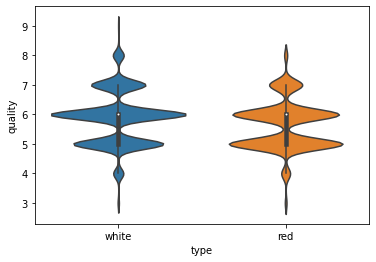

In [98]:
import seaborn as sns
sns.violinplot(data=winequalityN, x='type',y='quality')

In [99]:
condition=(winequalityN['type']=='red')

winequality_red=winequalityN[condition]
winequality_white=winequalityN[~condition]

print(len(winequality_red),len(winequality_white))

1599 4898


In [100]:
import scipy.stats as stats

F_statistic, pVal = stats.f_oneway(winequality_red['quality'],winequality_white['quality'])
print('데이터 일원분산분석 결과 : F={0:.5f}, p={1:0.5f}'.format(F_statistic, pVal))
if pVal<0.05:
  print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

데이터 일원분산분석 결과 : F=93.81181, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


In [101]:
from sklearn.metrics import accuracy_score
target='recommend'

baseline_red=winequality_red[target].mode()[0]
predict=[baseline_red]*len(winequality_red[target])
print(f"Accuracy_red: {accuracy_score(winequality_red[target],predict): .5f}")

baseline_white=winequality_white[target].mode()[0]
predict=[baseline_white]*len(winequality_white[target])
print(f"Accuracy_white: {accuracy_score(winequality_white[target],predict): .5f}")

Accuracy_red:  0.86429
Accuracy_white:  0.78359


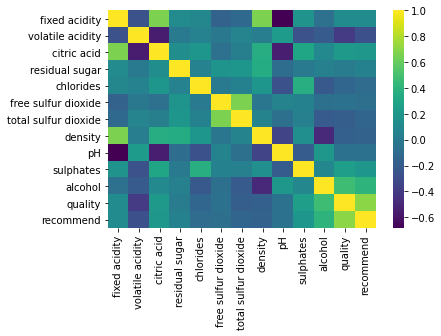

In [102]:
import seaborn as sns

corr_red=winequality_red.corr()
sns.heatmap(corr_red, cmap='viridis')

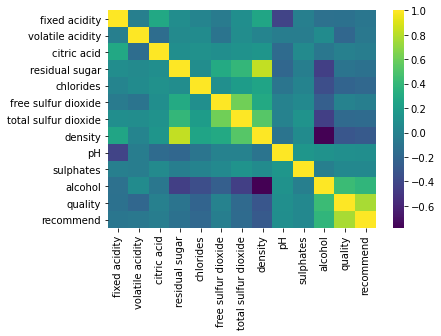

In [103]:
import seaborn as sns

corr_wh=winequality_white.corr()
sns.heatmap(corr_wh, cmap='viridis')

### regression

In [104]:
from sklearn.model_selection import train_test_split

# 레드 와인
train_red, test_red = train_test_split(winequality_red, test_size=0.2, random_state=2)
print(train_red.shape, test_red.shape)

train_red, val_red = train_test_split(train_red, test_size=0.2, random_state=2)
print(train_red.shape, val_red.shape)

target_red = 'quality'
feature_red = winequality_red.columns.drop([target_red,'type','recommend'])
X_train_red = train_red[feature_red]
y_train_red = train_red[target_red]
X_val_red = val_red[feature_red]
y_val_red = val_red[target_red]
X_test_red = test_red[feature_red]
y_test_red = test_red[target_red]

# 화이트 와인
train_wh, test_wh = train_test_split(winequality_white, test_size=0.2, random_state=2)
print(train_wh.shape, test_wh.shape)

train_wh, val_wh = train_test_split(train_wh, test_size=0.2, random_state=2)
print(train_wh.shape, val_wh.shape)

target_wh = 'quality'
feature_wh = winequality_white.columns.drop([target_wh,'type','recommend'])
X_train_wh = train_wh[feature_wh]
y_train_wh = train_wh[target_wh]
X_val_wh = val_wh[feature_wh]
y_val_wh = val_wh[target_wh]
X_test_wh = test_wh[feature_wh]
y_test_wh = test_wh[target_wh]

(1279, 14) (320, 14)
(1023, 14) (256, 14)
(3918, 14) (980, 14)
(3134, 14) (784, 14)


#### 레드 와인

In [105]:
from sklearn.linear_model import LinearRegression
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

linear_red = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),  
    LinearRegression()
)
                                     
linear_red.fit(X_train_red, y_train_red)

# 회귀계수
coefficients_red = linear_red.named_steps['linearregression'].coef_
pd.Series(coefficients_red, feature_red)

fixed acidity           0.015867
volatile acidity       -1.068935
citric acid            -0.154135
residual sugar         -0.007230
chlorides              -1.506909
free sulfur dioxide     0.004357
total sulfur dioxide   -0.003095
density                 3.584578
pH                     -0.281179
sulphates               0.876600
alcohol                 0.307394
dtype: float64

In [106]:
# 그래디언트 부스팅
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

boosting_red = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set_red = [(X_train_red, y_train_red), 
            (X_val_red, y_val_red)]

boosting_red.fit(X_train_red, y_train_red, 
          eval_set=eval_set_red,
          early_stopping_rounds=50
         )

y_pred_red = boosting_red.predict(X_test_red)
print('R^2', r2_score(y_test_red, y_pred_red))

[0]	validation_0-rmse:4.17299	validation_1-rmse:4.16069
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.36409	validation_1-rmse:3.35126
[2]	validation_0-rmse:2.71994	validation_1-rmse:2.70705
[3]	validation_0-rmse:2.209	validation_1-rmse:2.1999
[4]	validation_0-rmse:1.80565	validation_1-rmse:1.80139
[5]	validation_0-rmse:1.48921	validation_1-rmse:1.49723
[6]	validation_0-rmse:1.24191	validation_1-rmse:1.26296
[7]	validation_0-rmse:1.05213	validation_1-rmse:1.0873
[8]	validation_0-rmse:0.908342	validation_1-rmse:0.955955
[9]	validation_0-rmse:0.801312	validation_1-rmse:0.865505
[10]	validation_0-rmse:0.72353	validation_1-rmse:0.801514
[11]	validation_0-rmse:0.667106	validation_1-rmse:0.758449
[12]	validation_0-rmse:0.626759	validation_1-rmse:0.728399
[13]	validation_0-rmse:0.598841	validation_1-rmse:0.707759
[14]	validation_0-rmse:0.577662	validation_1-r

#### 화이트 와인

In [107]:
from sklearn.linear_model import LinearRegression
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

linear_wh = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),  
    LinearRegression()
)
                                     
linear_wh.fit(X_train_wh, y_train_wh)

# 회귀계수
coefficients_wh = linear_wh.named_steps['linearregression'].coef_
pd.Series(coefficients_wh, feature_wh)

fixed acidity             0.112419
volatile acidity         -2.036194
citric acid               0.041188
residual sugar            0.109438
chlorides                 0.542741
free sulfur dioxide       0.003893
total sulfur dioxide      0.000023
density                -228.798176
pH                        0.933895
sulphates                 0.625219
alcohol                   0.106144
dtype: float64

In [108]:
# 그래디언트 부스팅
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

boosting_wh = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set_wh = [(X_train_wh, y_train_wh), 
            (X_val_wh, y_val_wh)]

boosting_wh.fit(X_train_wh, y_train_wh, 
          eval_set=eval_set_wh,
          early_stopping_rounds=50
         )

y_pred_wh = boosting_wh.predict(X_test_wh)
print('R^2', r2_score(y_test_wh, y_pred_wh))


[0]	validation_0-rmse:4.39458	validation_1-rmse:4.36753
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.54516	validation_1-rmse:3.51859
[2]	validation_0-rmse:2.87134	validation_1-rmse:2.84634
[3]	validation_0-rmse:2.33872	validation_1-rmse:2.31751
[4]	validation_0-rmse:1.92102	validation_1-rmse:1.90084
[5]	validation_0-rmse:1.59586	validation_1-rmse:1.58111
[6]	validation_0-rmse:1.34484	validation_1-rmse:1.33355
[7]	validation_0-rmse:1.15512	validation_1-rmse:1.15154
[8]	validation_0-rmse:1.01302	validation_1-rmse:1.01719
[9]	validation_0-rmse:0.91032	validation_1-rmse:0.921904
[10]	validation_0-rmse:0.835486	validation_1-rmse:0.853741
[11]	validation_0-rmse:0.782933	validation_1-rmse:0.807556
[12]	validation_0-rmse:0.74651	validation_1-rmse:0.778452
[13]	validation_0-rmse:0.719718	validation_1-rmse:0.75643
[14]	validation_0-rmse:0.702014	validation_1-r

### classifier

In [109]:
train_red

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,recommend
5605,red,7.4,0.49,0.19,3.0,0.077,16.0,37.0,0.99660,3.37,0.51,10.5,5,False
5693,red,10.8,0.89,0.30,2.6,0.132,7.0,60.0,0.99786,2.99,1.18,10.2,5,False
6188,red,7.6,0.74,0.00,1.9,0.100,6.0,12.0,0.99521,3.36,0.59,11.0,5,False
5837,red,6.2,0.46,0.17,1.6,0.073,7.0,11.0,0.99425,3.61,0.54,11.4,5,False
6148,red,7.1,0.60,0.01,2.3,0.079,24.0,37.0,0.99514,3.40,0.61,10.9,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5494,red,12.4,0.40,0.51,2.0,0.059,6.0,24.0,0.99940,3.04,0.60,9.3,6,False
5441,red,11.2,0.66,0.24,2.5,0.085,16.0,53.0,0.99930,3.06,0.72,11.0,6,False
5582,red,9.8,0.98,0.32,2.3,0.078,35.0,152.0,0.99800,3.25,0.48,9.4,5,False
5569,red,8.2,0.73,0.21,1.7,0.074,5.0,13.0,0.99680,3.20,0.52,9.5,5,False


In [110]:
from sklearn.model_selection import train_test_split

# 레드 와인
train_red2, test_red2 = train_test_split(winequality_red, test_size=0.2, random_state=2)
print(train_red2.shape, test_red2.shape)

train_red2, val_red2 = train_test_split(train_red2, test_size=0.2, random_state=2)
print(train_red2.shape, val_red2.shape)

target_red2 = 'recommend'
feature_red2 = winequality_red.columns.drop([target_red2,'type','quality'])
X_train_red2 = train_red2[feature_red2]
y_train_red2 = train_red2[target_red2]
X_val_red2 = val_red2[feature_red2]
y_val_red2 = val_red2[target_red2]
X_test_red2 = test_red2[feature_red2]
y_test_red2 = test_red2[target_red2]

# 화이트 와인
train_wh2, test_wh2 = train_test_split(winequality_white, test_size=0.2, random_state=2)
print(train_wh2.shape, test_wh2.shape)

train_wh2, val_wh2 = train_test_split(train_wh2, test_size=0.2, random_state=2)
print(train_wh2.shape, val_wh2.shape)

target_wh2 = 'recommend'
feature_wh2 = winequality_white.columns.drop([target_wh2,'type','quality'])
X_train_wh2 = train_wh2[feature_wh2]
y_train_wh2 = train_wh2[target_wh2]
X_val_wh2 = val_wh2[feature_wh2]
y_val_wh2 = val_wh2[target_wh2]
X_test_wh2 = test_wh2[feature_wh2]
y_test_wh2 = test_wh2[target_wh2]

(1279, 14) (320, 14)
(1023, 14) (256, 14)
(3918, 14) (980, 14)
(3134, 14) (784, 14)


#### 레드 와인

In [111]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

pipe_decision_red = make_pipeline(
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe_decision_red.fit(X_train_red2, y_train_red2)
print('검증 정확도', pipe_decision_red.score(X_val_red2, y_val_red2))

검증 정확도 0.875


In [112]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

pipe_xgb_red = make_pipeline(
    SimpleImputer(strategy='mean'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe_xgb_red.fit(X_train_red2, y_train_red2);

In [113]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print('검증 정확도', pipe_xgb_red.score(X_val_red2, y_val_red2))

y_pred_red2 = pipe_xgb_red.predict(X_val_red2)
print('f1_score: ', f1_score(y_val_red2, y_pred_red2))

print(classification_report(y_pred_red2, y_val_red2))

검증 정확도 0.90625
f1_score:  0.6129032258064515
              precision    recall  f1-score   support

       False       0.97      0.93      0.95       230
        True       0.53      0.73      0.61        26

    accuracy                           0.91       256
   macro avg       0.75      0.83      0.78       256
weighted avg       0.92      0.91      0.91       256



In [114]:
import eli5
from eli5.sklearn import PermutationImportance

permuter_red = PermutationImportance(
    pipe_xgb_red, # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter_red.fit(X_val_red2, y_val_red2);

In [115]:
feature_names_red = X_val_red2.columns.tolist()
pd.Series(permuter_red.feature_importances_, feature_names_red).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter_red, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names_red # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0445 ± 0.0153,alcohol
0.0430 ± 0.0275,sulphates
0.0164 ± 0.0194,total sulfur dioxide
0.0133 ± 0.0117,volatile acidity
0.0117 ± 0.0156,fixed acidity
0.0078 ± 0.0070,free sulfur dioxide
0.0047 ± 0.0058,density
0.0008 ± 0.0058,chlorides
-0.0008 ± 0.0125,citric acid
-0.0063 ± 0.0038,pH


In [116]:
print('특성 삭제 전:', X_train_red2.shape, X_val_red2.shape, X_test_red2.shape)

minimum_importance = 0.001
mask = permuter_red.feature_importances_ > minimum_importance
features = X_train_red2.columns[mask]
X_train_selected_red2 = X_train_red2[features]
X_val_selected_red2 = X_val_red2[features]
X_test_selected_red2 = X_test_red2[features]

print('특성 삭제 후:', X_train_selected_red2.shape, X_val_selected_red2.shape, X_test_selected_red2.shape)

특성 삭제 전: (1023, 11) (256, 11) (320, 11)
특성 삭제 후: (1023, 7) (256, 7) (320, 7)


In [117]:
pipe_xgb_red2 = make_pipeline(
    SimpleImputer(strategy='mean'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe_xgb_red2.fit(X_train_selected_red2, y_train_red2);

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print('검증 정확도', pipe_xgb_red2.score(X_val_selected_red2, y_val_red2))

y_pred_selected_red2 = pipe_xgb_red2.predict(X_val_selected_red2)
print('f1_score: ', f1_score(y_val_red2, y_pred_selected_red2))

print(classification_report(y_pred_selected_red2, y_val_red2))

검증 정확도 0.921875
f1_score:  0.6774193548387097
              precision    recall  f1-score   support

       False       0.98      0.93      0.96       230
        True       0.58      0.81      0.68        26

    accuracy                           0.92       256
   macro avg       0.78      0.87      0.82       256
weighted avg       0.94      0.92      0.93       256



#### 화이트 와인

In [118]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

pipe_decision_wh = make_pipeline(
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe_decision_wh.fit(X_train_wh2, y_train_wh2)
print('검증 정확도', pipe_decision_wh.score(X_val_wh2, y_val_wh2))

검증 정확도 0.8035714285714286


In [119]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

pipe_xgb_wh = make_pipeline(
    SimpleImputer(strategy='mean'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe_xgb_wh.fit(X_train_wh2, y_train_wh2);

In [120]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print('검증 정확도', pipe_xgb_wh.score(X_val_wh2, y_val_wh2))

y_pred_wh2 = pipe_xgb_wh.predict(X_val_wh2)
print('f1_score: ', f1_score(y_val_wh2, y_pred_wh2))

print(classification_report(y_pred_wh2, y_val_wh2))

검증 정확도 0.8584183673469388
f1_score:  0.62876254180602
              precision    recall  f1-score   support

       False       0.94      0.88      0.91       656
        True       0.55      0.73      0.63       128

    accuracy                           0.86       784
   macro avg       0.75      0.81      0.77       784
weighted avg       0.88      0.86      0.87       784



In [121]:
import eli5
from eli5.sklearn import PermutationImportance

permuter_wh = PermutationImportance(
    pipe_xgb_wh, # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter_wh.fit(X_val_wh2, y_val_wh2);

In [122]:
feature_names_wh = X_val_wh2.columns.tolist()
pd.Series(permuter_wh.feature_importances_, feature_names_wh).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter_wh, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names_wh # list 형식으로 넣어야 합니다
)

# feature 값 모두 0.001 보다 큼, 특성 모두 사용

Weight,Feature
0.0408 ± 0.0187,alcohol
0.0311 ± 0.0103,volatile acidity
0.0268 ± 0.0108,residual sugar
0.0232 ± 0.0116,density
0.0219 ± 0.0109,pH
0.0214 ± 0.0083,free sulfur dioxide
0.0207 ± 0.0030,fixed acidity
0.0168 ± 0.0179,total sulfur dioxide
0.0122 ± 0.0108,citric acid
0.0120 ± 0.0047,sulphates


In [123]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

lgbm_wh = LGBMClassifier(n_estimators=200)

params_wh = {'max_depth': [10, 15, 20, 25],
          'min_child_samples': [10 ,20, 40, 60, 80],
          'subsample': [0.8, 1]}

grid_wh = GridSearchCV(lgbm_wh, param_grid=params_wh)
grid_wh.fit(X_train_wh2, y_train_wh2, early_stopping_rounds=100, eval_metric='auc',
         eval_set=[(X_train_wh2, y_train_wh2), (X_val_wh2, y_val_wh2)])

print("최적 하이퍼파라미터: ", grid_wh.best_params_)
lgbm_roc_score_wh = roc_auc_score(y_test_wh2, grid_wh.predict_proba(X_test_wh2)[:, 1], average='macro')
print("ROC AUC: {0:.4f}".format(lgbm_roc_score_wh))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[92]	valid_0's binary_logloss: 0.156399	valid_0's auc: 0.979116	valid_1's binary_logloss: 0.367471	valid_1's auc: 0.872165
[93]	valid_0's binary_logloss: 0.155459	valid_0's auc: 0.979295	valid_1's binary_logloss: 0.367801	valid_1's auc: 0.872251
[94]	valid_0's binary_logloss: 0.154586	valid_0's auc: 0.979427	valid_1's binary_logloss: 0.368367	valid_1's auc: 0.871641
[95]	valid_0's binary_logloss: 0.15365	valid_0's auc: 0.979649	valid_1's binary_logloss: 0.368748	valid_1's auc: 0.872051
[96]	valid_0's binary_logloss: 0.152762	valid_0's auc: 0.979661	valid_1's binary_logloss: 0.370119	valid_1's auc: 0.871765
[97]	valid_0's binary_logloss: 0.151974	valid_0's auc: 0.979653	valid_1's binary_logloss: 0.370407	valid_1's auc: 0.871536
[98]	valid_0's binary_logloss: 0.150727	valid_0's auc: 0.979887	valid_1's binary_logloss: 0.370529	valid_1's auc: 0.871698
[99]	valid_0's binary_logloss: 0.149808	valid_0's auc: 0.979971	valid_1's binary_logloss: 0.371466	valid

In [124]:
lgbm_grid_wh = grid_wh.best_estimator_

lgbm_grid_wh.fit(X_train_wh2, y_train_wh2)
y_pred_gridwh = lgbm_grid_wh.predict(X_val_wh2)
from sklearn.metrics import f1_score
print('f1_score: ', f1_score(y_val_wh2, y_pred_gridwh))

from sklearn.metrics import accuracy_score
print('accuracy_score: ', accuracy_score(y_val_wh2, y_pred_gridwh))

f1_score:  0.6308724832214764
accuracy_score:  0.8596938775510204


In [125]:
from sklearn.metrics import accuracy_score
y_pred_gridwh2 = lgbm_grid_wh.predict(X_test_wh2)
print('테스트 정확도: ', accuracy_score(y_test_wh2, y_pred_gridwh2))

테스트 정확도:  0.8683673469387755


In [197]:
import eli5
from eli5.sklearn import PermutationImportance

permuter_lgb_wh = PermutationImportance(
    lgbm_grid_wh, # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter_lgb_wh.fit(X_val_wh2, y_val_wh2);

In [198]:
feature_names_lgb_wh = X_val_wh2.columns.tolist()
pd.Series(permuter_lgb_wh.feature_importances_, feature_names_lgb_wh).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter_lgb_wh, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names_lgb_wh # list 형식으로 넣어야 합니다
)

# feature 값 모두 0.001 보다 큼, 특성 모두 사용

Weight,Feature
0.0500 ± 0.0198,alcohol
0.0273 ± 0.0110,residual sugar
0.0230 ± 0.0067,chlorides
0.0224 ± 0.0062,free sulfur dioxide
0.0212 ± 0.0099,pH
0.0209 ± 0.0149,total sulfur dioxide
0.0176 ± 0.0089,volatile acidity
0.0151 ± 0.0170,density
0.0125 ± 0.0080,fixed acidity
0.0074 ± 0.0136,citric acid


In [126]:
X_train_wh2.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [127]:
X_train_wh2.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,3129.000000,3131.000000,3133.000000,3132.000000,3133.000000,3134.000000,3134.000000,3134.000000,3130.000000,3133.000000,3134.000000
mean,6.853963,0.278125,0.333674,6.428528,0.046071,35.530313,138.045629,0.994044,3.187677,0.489524,10.500161
std,0.854996,0.100957,0.123760,5.049335,0.022309,16.494335,41.803835,0.002964,0.151743,0.115032,1.236368
min,3.900000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,24.000000,108.000000,0.991760,3.080000,0.410000,9.400000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993715,3.180000,0.470000,10.300000
75%,7.300000,0.320000,0.380000,10.000000,0.050000,46.000000,167.000000,0.996200,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,31.600000,0.301000,146.500000,366.500000,1.010300,3.820000,1.010000,14.200000


In [128]:
'''fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'''
test_case=[[7.3, 0.32, 0.38, 10, 0.05, 46, 167, 0.9962, 3.28, 0.55, 11.4]]
lgbm_grid_wh.predict(test_case)

# 모든 특성의 75%에 포함되는 케이스는 품질이 안좋다고 할 수 있다.

array([False])

In [129]:
test_case2=[[3.9, 0.32, 0.38, 10, 0.027, 43, 104, 0.9905, 3.02, 0.52, 11.3]]
lgbm_grid_wh.predict(test_case2)

# 품질이 좋은 케이스

array([ True])

In [130]:
# SHAP Force Plot
import shap

row_wh = X_val_wh2.iloc[[1]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row_wh

explainer_wh = shap.TreeExplainer(lgbm_grid_wh)
shap_values_wh = explainer_wh.shap_values(row_wh)

shap.initjs()
shap.force_plot(
    base_value=explainer_wh.expected_value[0], 
    shap_values=shap_values_wh[0],
    features=row_wh
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [131]:
X_train_wh2.shape, X_val_wh2.shape

((3134, 11), (784, 11))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


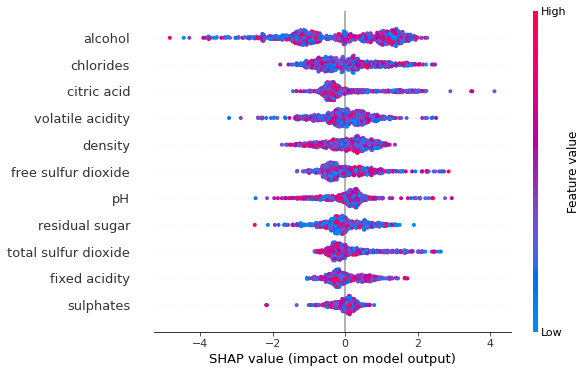

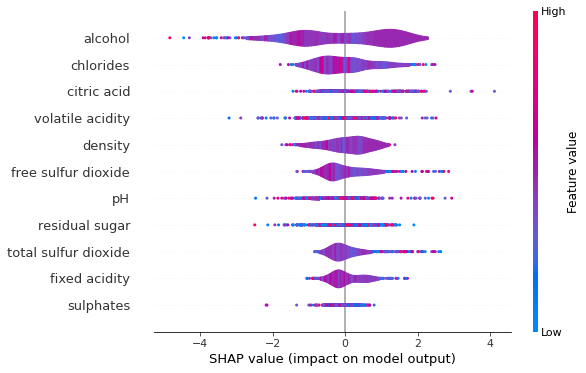

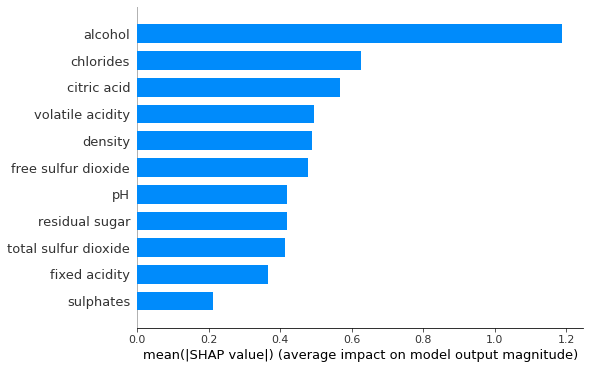

In [132]:
shap_values_wh2 = explainer_wh.shap_values(X_val_wh2.iloc[:784])
shap.summary_plot(shap_values_wh2[0], X_train_wh2.iloc[:784])
shap.summary_plot(shap_values_wh2[0], X_train_wh2.iloc[:784], plot_type="violin")
shap.summary_plot(shap_values_wh2[0], X_train_wh2.iloc[:784], plot_type="bar")

# 와인 평가 분석

In [133]:
import pandas as pd

winemag_150k= pd.read_csv('winemag-data_first150k.csv')
winemag_150k.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [134]:
# Unnamed: 0 의미 없는 컬럼
# description 문장 단위로 되어 있어 분석하기 어려울 것이라 판단
winemag_150k = winemag_150k.drop(['Unnamed: 0','description'],axis=1)
winemag_150k.head()

,country,designation,points,price,province,region_1,region_2,variety,winery
0,US,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [135]:
from pandas_profiling import ProfileReport
profile = ProfileReport(winemag_150k, minimal=True).to_notebook_iframe()
profile

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### country 칼럼

In [136]:
country_points=pd.crosstab(winemag_150k['country'],winemag_150k['points'])
country_points

points,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
country,,,,,,,,,,,,,,,,,,,,,
Albania,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
Argentina,153,224,307,595,636,671,678,700,523,348,304,200,163,77,32,10,7,3,0,0,0
Australia,9,43,106,182,337,393,537,636,601,594,626,365,259,140,47,40,14,14,11,0,3
Austria,0,1,14,25,47,125,193,314,446,469,537,306,232,186,101,38,17,5,1,0,0
Bosnia and Herzegovina,0,0,0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Brazil,0,3,7,4,7,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Bulgaria,4,0,2,12,11,12,11,8,3,9,5,0,0,0,0,0,0,0,0,0,0
Canada,0,0,2,5,13,13,10,28,27,23,40,23,9,3,0,0,0,0,0,0,0
Chile,80,135,237,448,617,730,859,822,697,475,325,221,108,54,7,1,0,0,0,0,0


In [137]:
country_points=winemag_150k.groupby(winemag_150k['country']).count()
country_points=country_points.sort_values(by='points',ascending=False)
country_points['points']

country
US                        62397
Italy                     23478
France                    21098
Spain                      8268
Chile                      5816
Argentina                  5631
Portugal                   5322
Australia                  4957
New Zealand                3320
Austria                    3057
Germany                    2452
South Africa               2258
Greece                      884
Israel                      630
Hungary                     231
Canada                      196
Romania                     139
Slovenia                     94
Uruguay                      92
Croatia                      89
Bulgaria                     77
Moldova                      71
Mexico                       63
Turkey                       52
Georgia                      43
Lebanon                      37
Cyprus                       31
Brazil                       25
Macedonia                    16
Serbia                       14
Morocco                      12


In [144]:
country_points=winemag_150k.groupby(winemag_150k['country']).mean()
country_points=country_points.sort_values(by='points',ascending=False)
country_points['points']

country
England                   92.888889
Austria                   89.276742
France                    88.925870
Germany                   88.626427
Italy                     88.413664
Canada                    88.239796
Slovenia                  88.234043
Morocco                   88.166667
Turkey                    88.096154
Portugal                  88.057685
Albania                   88.000000
US-France                 88.000000
Australia                 87.892475
US                        87.818789
Serbia                    87.714286
India                     87.625000
New Zealand               87.554217
Hungary                   87.329004
Switzerland               87.250000
South Africa              87.225421
Israel                    87.176190
Luxembourg                87.000000
Spain                     86.646589
Chile                     86.296768
Croatia                   86.280899
Greece                    86.117647
Tunisia                   86.000000
Argentina           

In [138]:
# 2000 이상으로 자름
high_country=country_points['points'][0:12].index
high_country

Index(['US', 'Italy', 'France', 'Spain', 'Chile', 'Argentina', 'Portugal',
       'Australia', 'New Zealand', 'Austria', 'Germany', 'South Africa'],
      dtype='object', name='country')

In [139]:
condition1=winemag_150k['country']==high_country[0]
condition2=winemag_150k['country']==high_country[1]
condition3=winemag_150k['country']==high_country[2]
condition4=winemag_150k['country']==high_country[3]
condition5=winemag_150k['country']==high_country[4]
condition6=winemag_150k['country']==high_country[5]
condition7=winemag_150k['country']==high_country[6]
condition8=winemag_150k['country']==high_country[7]
condition9=winemag_150k['country']==high_country[8]
condition10=winemag_150k['country']==high_country[9]
condition11=winemag_150k['country']==high_country[10]
condition12=winemag_150k['country']==high_country[11]

high_countries=winemag_150k[(condition1 | condition2 | condition3 | condition4 | condition5 | condition6 |
                            condition7 | condition8 | condition9 | condition10 | condition11 | condition12)]
high_countries

,country,designation,points,price,province,region_1,region_2,variety,winery
0,US,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...
150925,Italy,NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio
150926,France,Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain
150927,Italy,Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora
150928,France,Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset


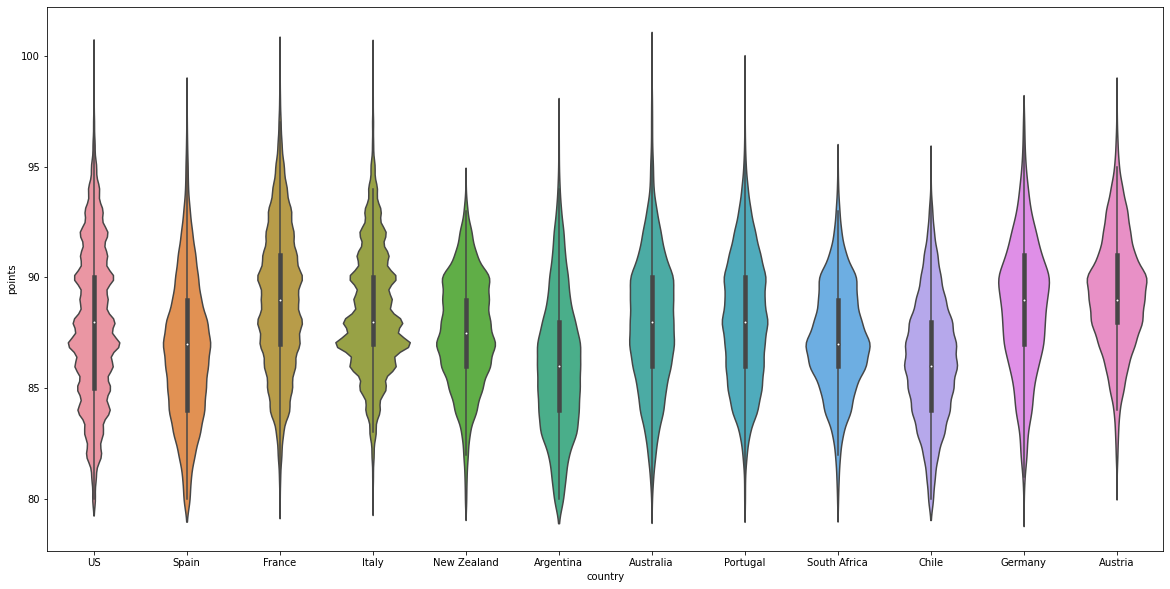

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
sns.violinplot(data=high_countries, x='country',y='points')

In [141]:
coun1=winemag_150k[condition1]
coun2=winemag_150k[condition2]
coun3=winemag_150k[condition3]
coun4=winemag_150k[condition4]
coun5=winemag_150k[condition5]
coun6=winemag_150k[condition6]
coun7=winemag_150k[condition7]
coun8=winemag_150k[condition8]
coun9=winemag_150k[condition9]
coun10=winemag_150k[condition10]
coun11=winemag_150k[condition11]
coun12=winemag_150k[condition12]

In [142]:
# 일원배치 분산분석
import scipy.stats as stats

F_statistic, pVal = stats.f_oneway(coun1['points'],coun2['points'],coun3['points'],coun4['points'],
                                   coun5['points'],coun6['points'],coun7['points'],coun8['points'],
                                   coun9['points'],coun10['points'],coun11['points'],coun12['points'])
print('데이터 일원분산분석 결과 : F={0:.5f}, p={1:0.5f}'.format(F_statistic, pVal))
if pVal<0.05:
  print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

데이터 일원분산분석 결과 : F=793.36433, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


In [149]:
# 비모수적 평균비교법
from scipy.stats import kruskal

kruskal(coun1['points'],coun2['points'],coun3['points'],coun4['points'],
        coun5['points'],coun6['points'],coun7['points'],coun8['points'],
        coun9['points'],coun10['points'],coun11['points'],coun12['points'])

KruskalResult(statistic=8015.688142989307, pvalue=0.0)

In [145]:
highcountry_points=high_countries.groupby(high_countries['country']).mean()
highcountry_points=highcountry_points.sort_values(by='points',ascending=False)
highcountry_points['points']

country
Austria         89.276742
France          88.925870
Germany         88.626427
Italy           88.413664
Portugal        88.057685
Australia       87.892475
US              87.818789
New Zealand     87.554217
South Africa    87.225421
Spain           86.646589
Chile           86.296768
Argentina       85.996093
Name: points, dtype: float64

In [151]:
total_mean = winemag_150k['points'].mean()
total_mean

87.8884184721394

In [153]:
from scipy import stats

stats.ttest_1samp(coun1['points'],total_mean)

Ttest_1sampResult(statistic=-5.100125441834868, pvalue=3.4041947861907424e-07)

In [169]:
from scipy import stats

stats.ttest_1samp(coun12['points'],total_mean)

Ttest_1sampResult(statistic=-13.160397060469363, pvalue=3.633731591861004e-38)

### provine 칼럼

In [157]:
province_points=winemag_150k.groupby(winemag_150k['province']).count()
province_points=province_points.sort_values(by='points',ascending=False)
province_points['points'][0:30]

province
California              44508
Washington               9750
Tuscany                  7281
Bordeaux                 6111
Northern Spain           4892
Mendoza Province         4742
Oregon                   4589
Burgundy                 4308
Piedmont                 4093
Veneto                   3962
South Australia          3004
Sicily & Sardinia        2545
New York                 2428
Northeastern Italy       1982
Loire Valley             1786
Alsace                   1680
Marlborough              1655
Southwest France         1601
Central Italy            1530
Southern Italy           1439
Champagne                1370
Catalonia                1352
Rhône Valley             1318
Colchagua Valley         1201
Languedoc-Roussillon     1082
Douro                    1075
Provence                 1021
Port                      903
Maipo Valley              895
Other                     889
Name: points, dtype: int64

In [158]:
# 2000 이상으로 자름
high_province=province_points['points'][0:13].index
high_province

Index(['California', 'Washington', 'Tuscany', 'Bordeaux', 'Northern Spain',
       'Mendoza Province', 'Oregon', 'Burgundy', 'Piedmont', 'Veneto',
       'South Australia', 'Sicily & Sardinia', 'New York'],
      dtype='object', name='province')

In [160]:
province1=winemag_150k['province']==high_province[0]
province2=winemag_150k['province']==high_province[1]
province3=winemag_150k['province']==high_province[2]
province4=winemag_150k['province']==high_province[3]
province5=winemag_150k['province']==high_province[4]
province6=winemag_150k['province']==high_province[5]
province7=winemag_150k['province']==high_province[6]
province8=winemag_150k['province']==high_province[7]
province9=winemag_150k['province']==high_province[8]
province10=winemag_150k['province']==high_province[9]
province11=winemag_150k['province']==high_province[10]
province12=winemag_150k['province']==high_province[11]
province13=winemag_150k['province']==high_province[12]

high_provinces=winemag_150k[(province1 | province2 | province3 | province4 | province5 | province6 |
                            province7 | province8 | province9 | province10 | province11 | province12 | province13)]

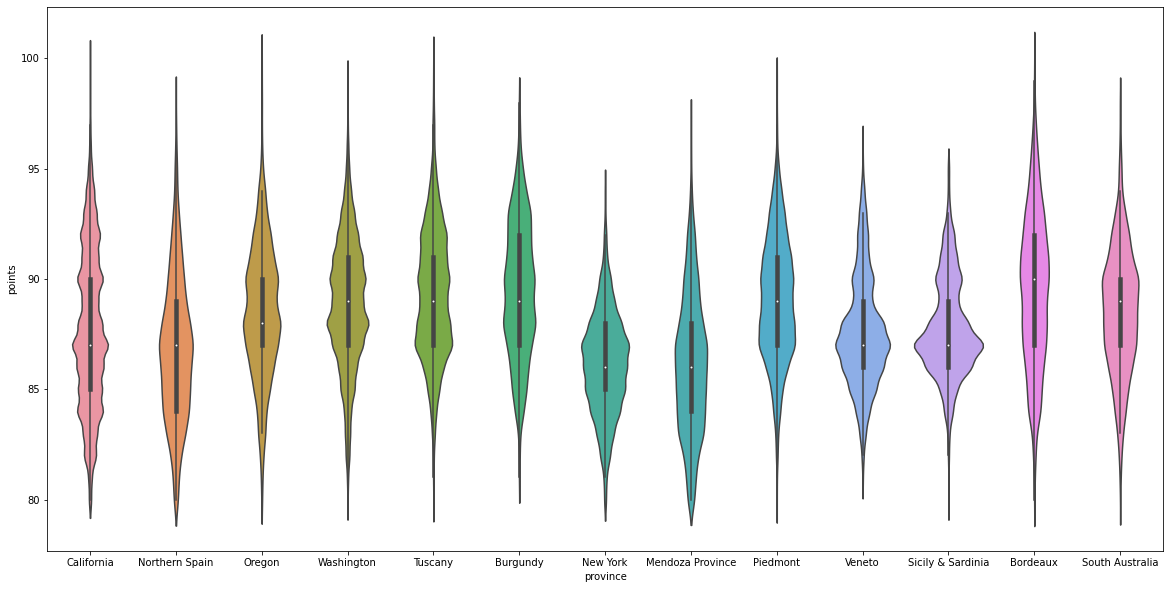

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
sns.violinplot(data=high_provinces, x='province',y='points')

In [165]:
prov1=winemag_150k[province1]
prov2=winemag_150k[province2]
prov3=winemag_150k[province3]
prov4=winemag_150k[province4]
prov5=winemag_150k[province5]
prov6=winemag_150k[province6]
prov7=winemag_150k[province7]
prov8=winemag_150k[province8]
prov9=winemag_150k[province9]
prov10=winemag_150k[province10]
prov11=winemag_150k[province11]
prov12=winemag_150k[province12]
prov13=winemag_150k[province13]

In [166]:
# 일원배치 분산분석
import scipy.stats as stats

F_statistic, pVal = stats.f_oneway(prov1['points'],prov2['points'],prov3['points'],prov4['points'],
                                   prov5['points'],prov6['points'],prov7['points'],prov8['points'],
                                   prov9['points'],prov10['points'],prov11['points'],prov12['points'],prov13['points'])
print('데이터 일원분산분석 결과 : F={0:.5f}, p={1:0.5f}'.format(F_statistic, pVal))
if pVal<0.05:
  print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

데이터 일원분산분석 결과 : F=703.36415, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


In [167]:
highprovince_points=high_provinces.groupby(high_provinces['province']).mean()
highprovince_points=highprovince_points.sort_values(by='points',ascending=False)
highprovince_points['points']

province
Bordeaux             89.497136
Burgundy             89.489090
Tuscany              89.284027
Piedmont             89.065233
Washington           88.879692
South Australia      88.544607
Oregon               88.509261
Sicily & Sardinia    87.758743
California           87.682731
Veneto               87.562342
Northern Spain       86.787204
New York             86.156507
Mendoza Province     86.108182
Name: points, dtype: float64

In [168]:
from scipy import stats

stats.ttest_1samp(prov1['points'],total_mean)

Ttest_1sampResult(statistic=-12.272313654543181, pvalue=1.4509130406544593e-34)

In [170]:
from scipy import stats

stats.ttest_1samp(prov13['points'],total_mean)

Ttest_1sampResult(statistic=-37.414750686300046, pvalue=2.6893515239125016e-242)

### region_1 칼럼

In [171]:
region_points=winemag_150k.groupby(winemag_150k['region_1']).count()
region_points=region_points.sort_values(by='points',ascending=False)
region_points['points'][0:30]

region_1
Napa Valley                6209
Columbia Valley (WA)       4975
Mendoza                    3586
Russian River Valley       3571
California                 3462
Paso Robles                3053
Willamette Valley          2096
Rioja                      1893
Toscana                    1885
Sonoma County              1853
Brunello di Montalcino     1746
Sicilia                    1701
Alsace                     1574
Sonoma Coast               1473
Carneros                   1458
Barolo                     1398
Dry Creek Valley           1398
Finger Lakes               1372
Champagne                  1369
Santa Barbara County       1319
Walla Walla Valley (WA)    1225
Yakima Valley              1162
Alexander Valley           1139
Chianti Classico           1029
Sta. Rita Hills             983
Sonoma Valley               971
Santa Lucia Highlands       962
Central Coast               950
Ribera del Duero            899
Santa Ynez Valley           898
Name: points, dtype: int64

In [173]:
# 1500 이상으로 자름
high_region=region_points['points'][0:13].index
high_region

Index(['Napa Valley', 'Columbia Valley (WA)', 'Mendoza',
       'Russian River Valley', 'California', 'Paso Robles',
       'Willamette Valley', 'Rioja', 'Toscana', 'Sonoma County',
       'Brunello di Montalcino', 'Sicilia', 'Alsace'],
      dtype='object', name='region_1')

In [174]:
region1=winemag_150k['region_1']==high_region[0]
region2=winemag_150k['region_1']==high_region[1]
region3=winemag_150k['region_1']==high_region[2]
region4=winemag_150k['region_1']==high_region[3]
region5=winemag_150k['region_1']==high_region[4]
region6=winemag_150k['region_1']==high_region[5]
region7=winemag_150k['region_1']==high_region[6]
region8=winemag_150k['region_1']==high_region[7]
region9=winemag_150k['region_1']==high_region[8]
region10=winemag_150k['region_1']==high_region[9]
region11=winemag_150k['region_1']==high_region[10]
region12=winemag_150k['region_1']==high_region[11]
region13=winemag_150k['region_1']==high_region[12]

high_regions=winemag_150k[(region1 | region2 | region3 | region4 | region5 | region6 |
                            region7 | region8 | region9 | region10 | region11 | region12 | region13)]

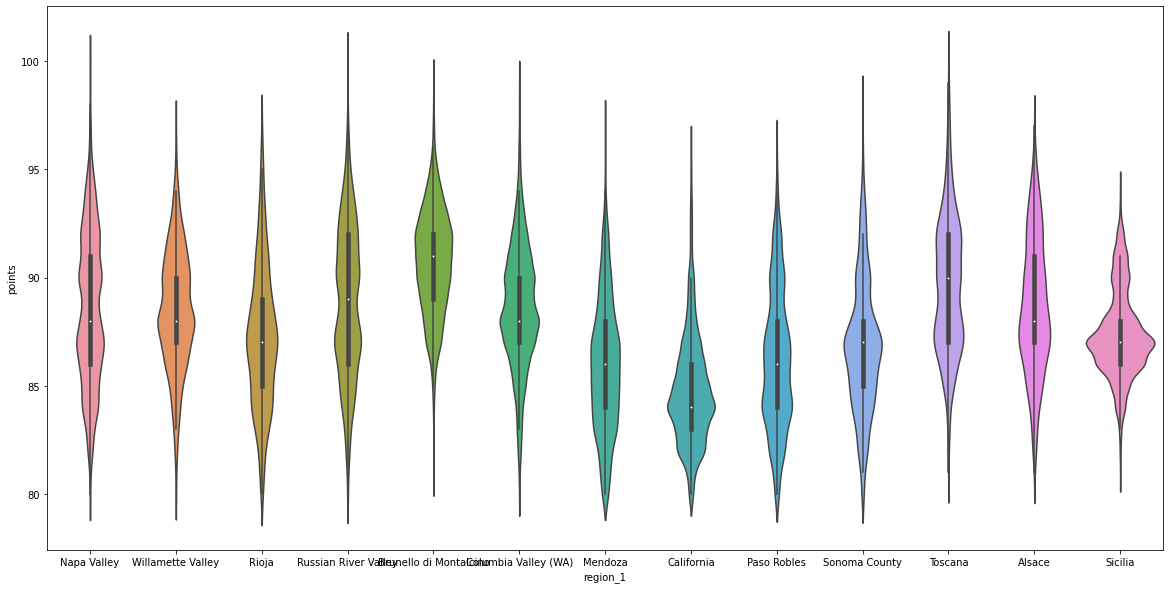

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
sns.violinplot(data=high_regions, x='region_1',y='points')

In [176]:
reg1=winemag_150k[region1]
reg2=winemag_150k[region2]
reg3=winemag_150k[region3]
reg4=winemag_150k[region4]
reg5=winemag_150k[region5]
reg6=winemag_150k[region6]
reg7=winemag_150k[region7]
reg8=winemag_150k[region8]
reg9=winemag_150k[region9]
reg10=winemag_150k[region10]
reg11=winemag_150k[region11]
reg12=winemag_150k[region12]
reg13=winemag_150k[region13]

In [177]:
# 일원배치 분산분석
import scipy.stats as stats

F_statistic, pVal = stats.f_oneway(reg1['points'],reg2['points'],reg3['points'],reg4['points'],
                                   reg5['points'],reg6['points'],reg7['points'],reg8['points'],
                                   reg9['points'],reg10['points'],reg11['points'],reg12['points'],reg13['points'])
print('데이터 일원분산분석 결과 : F={0:.5f}, p={1:0.5f}'.format(F_statistic, pVal))
if pVal<0.05:
  print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

데이터 일원분산분석 결과 : F=801.79077, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


In [178]:
highregion_points=high_regions.groupby(high_regions['region_1']).mean()
highregion_points=highregion_points.sort_values(by='points',ascending=False)
highregion_points['points']

region_1
Brunello di Montalcino    90.713058
Toscana                   89.615385
Russian River Valley      88.865304
Columbia Valley (WA)      88.636181
Alsace                    88.635959
Napa Valley               88.550813
Willamette Valley         88.480439
Sicilia                   87.378601
Rioja                     87.238246
Sonoma County             86.770642
Paso Robles               86.167049
Mendoza                   85.893753
California                84.813692
Name: points, dtype: float64

In [180]:
from scipy import stats

stats.ttest_1samp(reg1['points'],total_mean)

Ttest_1sampResult(statistic=15.006825169061617, pvalue=4.954360190378679e-50)

In [181]:
from scipy import stats

stats.ttest_1samp(reg13['points'],total_mean)

Ttest_1sampResult(statistic=9.537428179935125, pvalue=5.34251676159964e-21)

### variety 칼럼

In [182]:
variety_points=winemag_150k.groupby(winemag_150k['variety']).count()
variety_points=variety_points.sort_values(by='points',ascending=False)
variety_points['points'][0:30]

variety
Chardonnay                       14482
Pinot Noir                       14291
Cabernet Sauvignon               12800
Red Blend                        10062
Bordeaux-style Red Blend          7347
Sauvignon Blanc                   6320
Syrah                             5825
Riesling                          5524
Merlot                            5070
Zinfandel                         3799
Sangiovese                        3345
Malbec                            3208
White Blend                       2824
Rosé                              2817
Tempranillo                       2556
Nebbiolo                          2241
Portuguese Red                    2216
Sparkling Blend                   2004
Shiraz                            1970
Corvina, Rondinella, Molinara     1682
Rhône-style Red Blend             1505
Barbera                           1365
Pinot Gris                        1365
Cabernet Franc                    1363
Sangiovese Grosso                 1346
Pinot Grigio     

In [183]:
# 3000 이상으로 자름
high_variety=variety_points['points'][0:12].index
high_variety

Index(['Chardonnay', 'Pinot Noir', 'Cabernet Sauvignon', 'Red Blend',
       'Bordeaux-style Red Blend', 'Sauvignon Blanc', 'Syrah', 'Riesling',
       'Merlot', 'Zinfandel', 'Sangiovese', 'Malbec'],
      dtype='object', name='variety')

In [184]:
variety1=winemag_150k['variety']==high_variety[0]
variety2=winemag_150k['variety']==high_variety[1]
variety3=winemag_150k['variety']==high_variety[2]
variety4=winemag_150k['variety']==high_variety[3]
variety5=winemag_150k['variety']==high_variety[4]
variety6=winemag_150k['variety']==high_variety[5]
variety7=winemag_150k['variety']==high_variety[6]
variety8=winemag_150k['variety']==high_variety[7]
variety9=winemag_150k['variety']==high_variety[8]
variety10=winemag_150k['variety']==high_variety[9]
variety11=winemag_150k['variety']==high_variety[10]
variety12=winemag_150k['variety']==high_variety[11]

high_varieties=winemag_150k[(variety1 | variety2 | variety3 | variety4 | variety5 | variety6 |
                            variety7 | variety8 | variety9 | variety10 | variety11 | variety12 )]

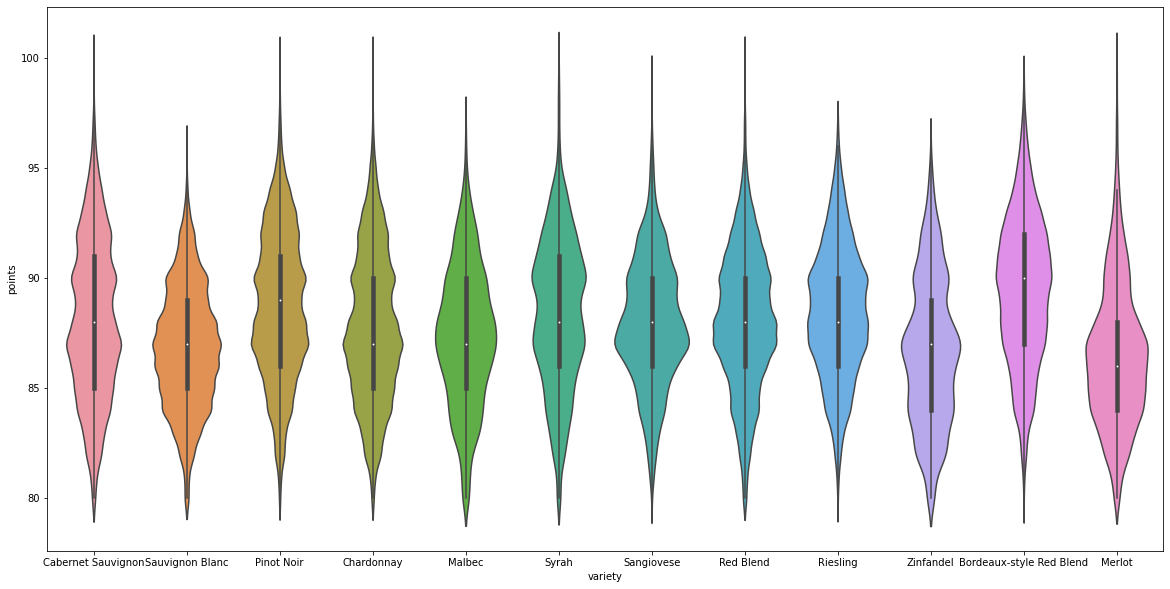

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
sns.violinplot(data=high_varieties, x='variety',y='points')

In [187]:
vari1=winemag_150k[variety1]
vari2=winemag_150k[variety2]
vari3=winemag_150k[variety3]
vari4=winemag_150k[variety4]
vari5=winemag_150k[variety5]
vari6=winemag_150k[variety6]
vari7=winemag_150k[variety7]
vari8=winemag_150k[variety8]
vari9=winemag_150k[variety9]
vari10=winemag_150k[variety10]
vari11=winemag_150k[variety11]
vari12=winemag_150k[variety12]

In [188]:

# 일원배치 분산분석
import scipy.stats as stats

F_statistic, pVal = stats.f_oneway(vari1['points'],vari2['points'],vari3['points'],vari4['points'],
                                   vari5['points'],vari6['points'],vari7['points'],vari8['points'],
                                   vari9['points'],vari10['points'],vari11['points'],vari12['points'])
print('데이터 일원분산분석 결과 : F={0:.5f}, p={1:0.5f}'.format(F_statistic, pVal))
if pVal<0.05:
  print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

데이터 일원분산분석 결과 : F=467.99805, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


In [189]:
highvariety_points=high_varieties.groupby(high_varieties['variety']).mean()
highvariety_points=highvariety_points.sort_values(by='points',ascending=False)
highvariety_points['points']

variety
Bordeaux-style Red Blend    89.466857
Pinot Noir                  88.719404
Riesling                    88.461079
Syrah                       88.376824
Cabernet Sauvignon          88.080391
Red Blend                   88.063606
Sangiovese                  87.944395
Chardonnay                  87.746789
Malbec                      87.365025
Sauvignon Blanc             86.835285
Zinfandel                   86.667281
Merlot                      86.498225
Name: points, dtype: float64

In [190]:
from scipy import stats

stats.ttest_1samp(vari1['points'],total_mean)

Ttest_1sampResult(statistic=-5.106865093323971, pvalue=3.317055708658451e-07)

In [191]:
from scipy import stats

stats.ttest_1samp(vari12['points'],total_mean)

Ttest_1sampResult(statistic=-9.38681075832572, pvalue=1.1357481592514209e-20)

### 정리

In [194]:
results=pd.DataFrame({'country':high_country[0:3],'province':high_province[0:3],'region':high_region[0:3],'variety':high_variety[0:3]})
results

,country,province,region,variety
0,US,California,Napa Valley,Chardonnay
1,Italy,Washington,Columbia Valley (WA),Pinot Noir
2,France,Tuscany,Mendoza,Cabernet Sauvignon


# 결과

레드 와인과 화이트 와인의 종류에 따라 영향을 받는 성분에 차이가 있다

레드 와인은 alcohol, sulphates, total sulfur dioxide 에 영향을 받고

화이트 와인은 alcohol, chlorides 에 영향을 받는다.


In [195]:
results

,country,province,region,variety
0,US,California,Napa Valley,Chardonnay
1,Italy,Washington,Columbia Valley (WA),Pinot Noir
2,France,Tuscany,Mendoza,Cabernet Sauvignon
